# About

This notebook shows how to convert `.nii` [BraTS 2020](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/) training data to TFRecord format. The full converted tfrecord dataset (output of this notebook) can be found [here](https://www.kaggle.com/datasets/ipythonx/brats2020).

In [1]:
import logging
logging.disable(logging.WARNING)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import os
import numpy as np
import tensorflow as tf
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_datalist(root_dir: str):
    """
    Load image/label paths of dataset from a directory structure.
    Expects subdirectories named after each sample containing files:
    - {sample}_flair.nii
    - {sample}_t1.nii
    - {sample}_t1ce.nii
    - {sample}_t2.nii
    - {sample}_seg.nii
    """
    model_scans = ["flair", "t1", "t1ce", "t2"]
    datalist = []

    for data in os.listdir(root_dir):
        data_dir = os.path.join(root_dir, data)
        if not os.path.isdir(data_dir):
            continue

        image_paths = [os.path.join(data_dir, f"{data}_{scan}.nii") for scan in model_scans]
        label_path = os.path.join(data_dir, f"{data}_seg.nii")

        if all(os.path.exists(p) for p in image_paths + [label_path]):
            datalist.append({
                "image": image_paths,
                "label": label_path
            })

    return datalist


In [3]:
root_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
datalist = load_datalist(root_dir)
len(datalist)

368

In [4]:
flair = datalist[0]['image'][0]
t1 = datalist[0]['image'][1]
t1ce = datalist[0]['image'][2]
t2 = datalist[0]['image'][3]
seg = datalist[0]['label']

flair_nii = nib.load(flair)
seg_nii = nib.load(seg)
flair_nii.shape, seg_nii.shape

((240, 240, 155), (240, 240, 155))

In [5]:
flair_nii.affine

array([[ -1.,  -0.,  -0.,   0.],
       [ -0.,  -1.,  -0., 239.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [6]:
np.unique(seg_nii.get_fdata())

array([0., 1., 2., 4.])

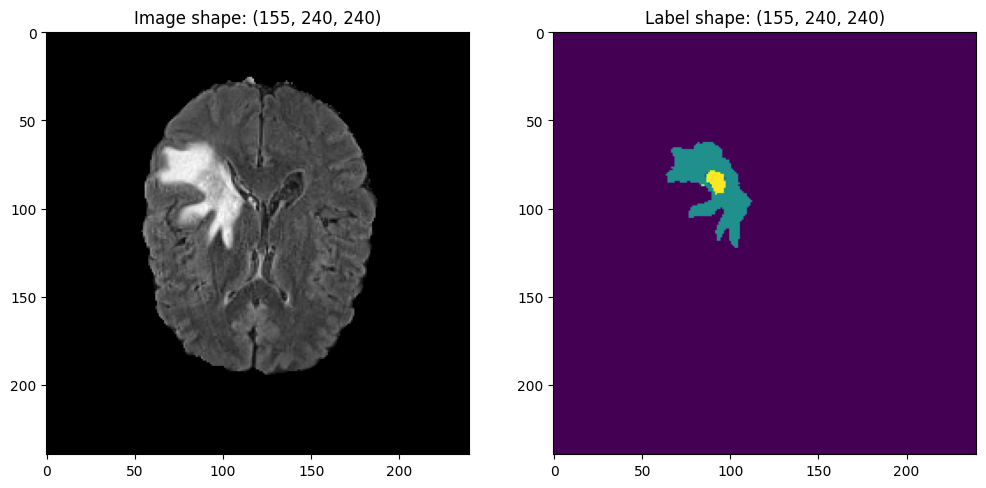

In [7]:
test_image = np.transpose(flair_nii.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_mask = np.transpose(seg_nii.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

# TFRecord Creation

In [9]:
def serialize_example(image_paths, label_path):
    # Extract file names
    image_filenames = [
        os.path.basename(p) for p in image_paths
    ]
    label_filename = os.path.basename(label_path)

    # Load images
    images = [
        nib.load(p).get_fdata().astype(np.float32) 
        for p in image_paths
    ]
    label = nib.load(label_path).get_fdata().astype(np.float32)

    # Load metadata
    image_shapes = [
        np.array(img.shape, dtype=np.int64) 
        for img in images
    ]
    label_shape = np.array(label.shape, dtype=np.int64)

    image_affines = [
        nib.load(p).affine.flatten() 
        for p in image_paths
    ]
    label_affine = nib.load(label_path).affine.flatten()

    image_pixdims = [
        np.array(nib.load(p).header['pixdim'], dtype=np.float32) 
        for p in image_paths
    ]
    label_pixdim = np.array(
        nib.load(label_path).header['pixdim'], dtype=np.float32
    )

    # Convert to raw bytes
    image_raws = [img.tobytes() for img in images]
    label_raw = label.tobytes()

    feature = {
        "flair_raw": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_raws[0]])
        ),
        "t1_raw": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_raws[1]])
        ),
        "t1ce_raw": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_raws[2]])
        ),
        "t2_raw": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_raws[3]])
        ),
        "label_raw": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[label_raw])
        ),

        "flair_shape": tf.train.Feature(
            int64_list=tf.train.Int64List(value=image_shapes[0])
        ),
        "t1_shape": tf.train.Feature(
            int64_list=tf.train.Int64List(value=image_shapes[1])
        ),
        "t1ce_shape": tf.train.Feature(
            int64_list=tf.train.Int64List(value=image_shapes[2])
        ),
        "t2_shape": tf.train.Feature(
            int64_list=tf.train.Int64List(value=image_shapes[3])
        ),
        "label_shape": tf.train.Feature(
            int64_list=tf.train.Int64List(value=label_shape)
        ),

        "flair_affine": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_affines[0])
        ),
        "t1_affine": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_affines[1])
        ),
        "t1ce_affine": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_affines[2])
        ),
        "t2_affine": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_affines[3])
        ),
        "label_affine": tf.train.Feature(
            float_list=tf.train.FloatList(value=label_affine)
        ),

        "flair_pixdim": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_pixdims[0])
        ),
        "t1_pixdim": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_pixdims[1])
        ),
        "t1ce_pixdim": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_pixdims[2])
        ),
        "t2_pixdim": tf.train.Feature(
            float_list=tf.train.FloatList(value=image_pixdims[3])
        ),
        "label_pixdim": tf.train.Feature(
            float_list=tf.train.FloatList(value=label_pixdim)
        ),

        # Store file names
        "flair_filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_filenames[0].encode()])
        ),
        "t1_filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_filenames[1].encode()])
        ),
        "t1ce_filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_filenames[2].encode()])
        ),
        "t2_filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_filenames[3].encode()])
        ),
        "label_filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[label_filename.encode()])
        )
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

In [10]:
output_dir = "tfrecords"
os.makedirs(output_dir, exist_ok=True)

def create_tfrec(dataset, shard_size=3, set='training'):
    num_shards = (len(dataset) + shard_size - 1) // shard_size
    
    for shard_idx in range(num_shards):
        shard_path = os.path.join(output_dir, f"{set}_shard_{shard_idx}.tfrec")
        start_idx = shard_idx * shard_size
        end_idx = min(start_idx + shard_size, len(dataset))
    
        with tf.io.TFRecordWriter(shard_path) as writer:
            for i in tqdm(
                range(start_idx, end_idx), 
                desc=f"Writing Shard {shard_idx}/{num_shards-1}"
            ):
                sample = dataset[i]
                tf_example = serialize_example(sample["image"], sample["label"])
                writer.write(tf_example)
    
        print(f"Shard {shard_idx} for {set} saved: {shard_path}")

This dataset is too big for kaggle output disk space. So, we will pick few sample for demonstration purpose.

In [12]:
create_tfrec(datalist[:30], shard_size=5, set='training')

Writing Shard 0/5: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Shard 0 for training saved: tfrecords/training_shard_0.tfrec


Writing Shard 1/5: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Shard 1 for training saved: tfrecords/training_shard_1.tfrec


Writing Shard 2/5: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Shard 2 for training saved: tfrecords/training_shard_2.tfrec


Writing Shard 3/5: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


Shard 3 for training saved: tfrecords/training_shard_3.tfrec


Writing Shard 4/5: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Shard 4 for training saved: tfrecords/training_shard_4.tfrec


Writing Shard 5/5: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

Shard 5 for training saved: tfrecords/training_shard_5.tfrec


# TFRecord Decode

In [13]:
import tensorflow as tf

def parse_tfrecord_fn(example_proto):
    feature_description = {
        # Image raw data
        "flair_raw": tf.io.FixedLenFeature([], tf.string),
        "t1_raw": tf.io.FixedLenFeature([], tf.string),
        "t1ce_raw": tf.io.FixedLenFeature([], tf.string),
        "t2_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),

        # Image shape
        "flair_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t1_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t1ce_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t2_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),

        # Affine matrices (4x4 = 16 values)
        "flair_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t1_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t1ce_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t2_affine": tf.io.FixedLenFeature([16], tf.float32),
        "label_affine": tf.io.FixedLenFeature([16], tf.float32),

        # Voxel Spacing (pixdim)
        "flair_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t1_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t1ce_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t2_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "label_pixdim": tf.io.FixedLenFeature([8], tf.float32),

        # Filenames
        "flair_filename": tf.io.FixedLenFeature([], tf.string),
        "t1_filename": tf.io.FixedLenFeature([], tf.string),
        "t1ce_filename": tf.io.FixedLenFeature([], tf.string),
        "t2_filename": tf.io.FixedLenFeature([], tf.string),
        "label_filename": tf.io.FixedLenFeature([], tf.string),
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode image and label data
    flair = tf.io.decode_raw(example["flair_raw"], tf.float32)
    t1 = tf.io.decode_raw(example["t1_raw"], tf.float32)
    t1ce = tf.io.decode_raw(example["t1ce_raw"], tf.float32)
    t2 = tf.io.decode_raw(example["t2_raw"], tf.float32)
    label = tf.io.decode_raw(example["label_raw"], tf.float32)

    # Reshape to original dimensions
    flair = tf.reshape(flair, example["flair_shape"])
    t1 = tf.reshape(t1, example["t1_shape"])
    t1ce = tf.reshape(t1ce, example["t1ce_shape"])
    t2 = tf.reshape(t2, example["t2_shape"])
    label = tf.reshape(label, example["label_shape"])

    # Decode affine matrices
    flair_affine = tf.reshape(example["flair_affine"], (4, 4))
    t1_affine = tf.reshape(example["t1_affine"], (4, 4))
    t1ce_affine = tf.reshape(example["t1ce_affine"], (4, 4))
    t2_affine = tf.reshape(example["t2_affine"], (4, 4))
    label_affine = tf.reshape(example["label_affine"], (4, 4))

    # Decode voxel spacing (pixdim)
    flair_pixdim = example["flair_pixdim"]
    t1_pixdim = example["t1_pixdim"]
    t1ce_pixdim = example["t1ce_pixdim"]
    t2_pixdim = example["t2_pixdim"]
    label_pixdim = example["label_pixdim"]

    # Decode filenames
    flair_filename = example["flair_filename"]
    t1_filename = example["t1_filename"]
    t1ce_filename = example["t1ce_filename"]
    t2_filename = example["t2_filename"]
    label_filename = example["label_filename"]

    return (
        flair, t1, t1ce, t2, label,
        flair_affine, t1_affine, t1ce_affine, t2_affine, label_affine,
        flair_pixdim, t1_pixdim, t1ce_pixdim, t2_pixdim, label_pixdim,
        flair_filename, t1_filename, t1ce_filename, t2_filename, label_filename
    )

In [14]:
# Load and decode dataset
tfrecord_path = "tfrecords/training_shard_0.tfrec"
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord_fn)

# Iterate over the dataset
for (
    flair, t1, t1ce, t2, label,
    flair_affine, t1_affine, t1ce_affine, t2_affine, label_affine,
    flair_pixdim, t1_pixdim, t1ce_pixdim, t2_pixdim, label_pixdim,
    flair_filename, t1_filename, t1ce_filename, t2_filename, label_filename
) in dataset:
    print("Filenames:")
    print(" - FLAIR:", flair_filename.numpy().decode('utf-8'))
    print(" - T1:", t1_filename.numpy().decode('utf-8'))
    print(" - T1CE:", t1ce_filename.numpy().decode('utf-8'))
    print(" - T2:", t2_filename.numpy().decode('utf-8'))
    print(" - Label:", label_filename.numpy().decode('utf-8'))
    
    print("\nShapes:")
    print(" - FLAIR:", flair.shape)
    print(" - T1:", t1.shape)
    print(" - T1CE:", t1ce.shape)
    print(" - T2:", t2.shape)
    print(" - Label:", label.shape)
    
    print("\nAffine Matrices:")
    print(" - FLAIR:\n", flair_affine.numpy())
    print(" - T1:\n", t1_affine.numpy())
    print(" - T1CE:\n", t1ce_affine.numpy())
    print(" - T2:\n", t2_affine.numpy())
    print(" - Label:\n", label_affine.numpy())

    print("\nVoxel Spacing:")
    print(" - FLAIR:", flair_pixdim.numpy())
    print(" - T1:", t1_pixdim.numpy())
    print(" - T1CE:", t1ce_pixdim.numpy())
    print(" - T2:", t2_pixdim.numpy())
    print(" - Label:", label_pixdim.numpy())

    break  # Print only one sample for verification


Filenames:
 - FLAIR: BraTS20_Training_083_flair.nii
 - T1: BraTS20_Training_083_t1.nii
 - T1CE: BraTS20_Training_083_t1ce.nii
 - T2: BraTS20_Training_083_t2.nii
 - Label: BraTS20_Training_083_seg.nii

Shapes:
 - FLAIR: (240, 240, 155)
 - T1: (240, 240, 155)
 - T1CE: (240, 240, 155)
 - T2: (240, 240, 155)
 - Label: (240, 240, 155)

Affine Matrices:
 - FLAIR:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
 - T1:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
 - T1CE:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
 - T2:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
 - Label:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]

Voxel Spacing:
 - FLAIR: [1. 1. 1. 1. 0. 0. 0. 0.]
 - T1: [1. 1. 1. 1. 0. 0. 0. 0.]
 - T1CE: [1. 1. 1. 1. 0. 0. 0. 0.]
 - T2: [1. 1. 1. 

# Dataloader

In [15]:
def load_tfrecord_dataset(tfrecord_pattern, batch_size=1):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_pattern))
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

tfrecord_pattern = "tfrecords/{}_shard_*.tfrec"
train_ds = load_tfrecord_dataset(tfrecord_pattern.format("training"), batch_size=1)

In [16]:
sample = next(iter(train_ds))
len(sample)

20

In [17]:
flair, t1, t1ce, t2, label = sample[:5]
flair.shape, t1.shape, t1ce.shape, t2.shape, label.shape

(TensorShape([1, 240, 240, 155]),
 TensorShape([1, 240, 240, 155]),
 TensorShape([1, 240, 240, 155]),
 TensorShape([1, 240, 240, 155]),
 TensorShape([1, 240, 240, 155]))

In [18]:
flair = flair.numpy().squeeze()
t1 = t1.numpy().squeeze()
t1ce = t1ce.numpy().squeeze()
t2 = t2.numpy().squeeze()
label = label.numpy().squeeze()
flair.shape, t1.shape, t1ce.shape, t2.shape, label.shape, np.unique(label)

((240, 240, 155),
 (240, 240, 155),
 (240, 240, 155),
 (240, 240, 155),
 (240, 240, 155),
 array([0., 1., 2., 4.], dtype=float32))

[0. 1. 2. 4.]


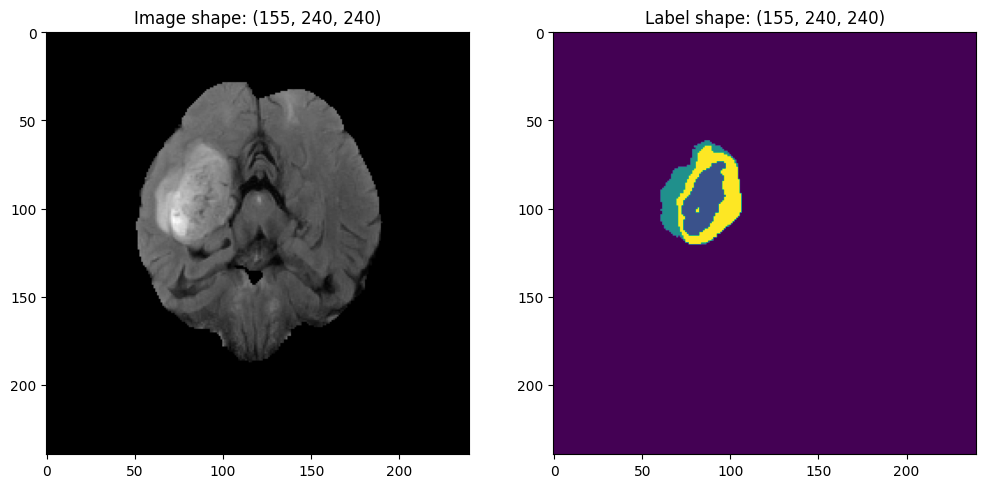

In [19]:
test_image = np.transpose(flair, (2, 1, 0))[:, -1::-1, -1::-1]
test_mask = np.transpose(label, (2, 1, 0))[:, -1::-1, -1::-1]
print(np.unique(test_mask))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//3], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//3])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()